In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset from CSV file 
df = pd.read_csv('qubit_measurements.csv')

print("First few rows of the dataset:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

First few rows of the dataset:
    sigma_x   sigma_y   sigma_z     theta       phi
0 -0.778195  0.525444  0.343977  1.176652  2.473285
1 -0.202425  0.020035 -0.979093  2.986757  2.974684
2  0.473190 -0.514778 -0.714909  2.299627  5.369280
3 -0.534334  0.778968 -0.328171  1.880741  2.136311
4  0.353171 -0.398269  0.846553  0.490147  5.464170

Dataset statistics:
           sigma_x      sigma_y      sigma_z        theta          phi
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000
mean     -0.013492     0.014582     0.006340     1.560844     3.088105
std       0.503342     0.495064     0.708043     0.909911     1.794581
min      -0.999286    -0.999548    -0.999989     0.000037     0.000332
25%      -0.383271    -0.334406    -0.695582     0.766118     1.552864
50%      -0.006437     0.017824     0.002392     1.570823     3.053449
75%       0.344755     0.362260     0.712115     2.350228     4.607910
max       0.999334     0.998738     0.999995     3.140706     6.2800

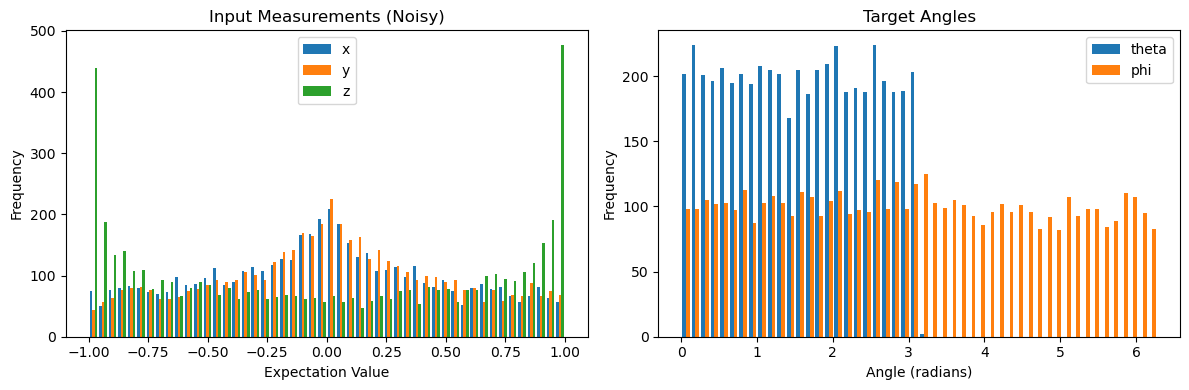

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of noisy Pauli measurements (inputs)
axs[0].hist(df[['sigma_x', 'sigma_y', 'sigma_z']].values, bins=50, label=['x', 'y', 'z'])
axs[0].set_title('Input Measurements (Noisy)')
axs[0].set_xlabel('Expectation Value')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Histogram of target parameters (theta, phi)
axs[1].hist(df[['theta', 'phi']].values, bins=50, label=['theta', 'phi'])
axs[1].set_title('Target Angles')
axs[1].set_xlabel('Angle (radians)')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.tight_layout()
plt.show()

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# -------------------------------
# Split (sigma_x, sigma_y, sigma_z) and (theta and phi)
# -------------------------------
X = df[['sigma_x', 'sigma_y', 'sigma_z']].values

y = df[['theta', 'phi']].values

# -------------------------------
# Split into training and test sets (80% train, 20% test)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# -------------------------------
# 3. Convert to PyTorch tensors
# -------------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# -------------------------------
# 4. Wrap into TensorDatasets
# -------------------------------
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# -------------------------------
# 5. Create DataLoaders
# -------------------------------
#Load data in batches during training
batch_size = 64 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")

Training samples: 4000
Test samples: 1000
Data loaders created successfully.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define neural network class
class BayesianQubitRegressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2, dropout_rate=0.2):
        """
        input_dim: number of input features (sigma_x, sigma_y, sigma_z)
        hidden_dim: number of hidden units in each layer
        output_dim: number of outputs (theta, phi)
        dropout_rate: probability of dropout 
        """
        super(BayesianQubitRegressor, self).__init__()

        # First linear layer: input -> hidden
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Second linear layer: hidden -> hidden
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # Final linear layer: hidden -> output
        self.output = nn.Linear(hidden_dim, output_dim)

        # Dropout layer (used between layers to create randomness)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        """
        Forward pass through the network.
        Dropout is active during both training and test time for MC sampling.
        """
        x = F.relu(self.fc1(x))            # First layer with ReLU activation
        x = self.dropout(x)                # Dropout adds randomness for Bayesian sampling
        x = F.relu(self.fc2(x))            # Second layer with ReLU
        x = self.dropout(x)                # Dropout again
        out = self.output(x)               # Final output layer
        return out

In [ ]:
# Create a model instance
model = BayesianQubitRegressor()

print(model)

BayesianQubitRegressor(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [6]:
import torch.optim as optim
import time

# -------------------------------
# Loss function
# -------------------------------
# Mean Squared Error standard for regression tasks 
loss_fn = nn.MSELoss() 

# -------------------------------
# Optimizer
# -------------------------------
# Adam optimizer adapts learning rates
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -------------------------------
# Training loop parameters
# -------------------------------
n_epochs = 100                 # Number of times to pass over the full training set
train_losses = []             # Track training loss per epoch
test_losses = []              # Track test loss per epoch

# -------------------------------
# Move model to appropriate device 
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Training on device: {device}")

Training on device: cpu


In [7]:
from tqdm import tqdm  

# Move loss function to same device as model
loss_fn = loss_fn.to(device)

# Training loop
for epoch in range(n_epochs):
    model.train()  # Set model to training mode (activates dropout)

    running_loss = 0.0  # Tracks loss for this epoch

    # -------------------------------
    # Train over all batches
    # -------------------------------
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        # Zero out gradients from last pass
        optimizer.zero_grad()

        # Forward pass: compute model predictions
        outputs = model(batch_inputs)

        # Compute MSE loss between predicted and true angles
        loss = loss_fn(outputs, batch_targets)

        # Backward pass: compute gradients
        loss.backward()

        # Update weights using optimizer
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Average training loss for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # -------------------------------
    # Evaluate on test set 
    # -------------------------------
    model.train()  
    test_running_loss = 0.0

    with torch.no_grad():
        for batch_inputs, batch_targets in test_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            outputs = model(batch_inputs)

            loss = loss_fn(outputs, batch_targets)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    # -------------------------------
    # Progress
    # -------------------------------
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>3} / {n_epochs} | Train Loss: {epoch_train_loss:.5f} | Test Loss: {epoch_test_loss:.5f}")

Epoch   1 / 100 | Train Loss: 2.76524 | Test Loss: 0.97307
Epoch  10 / 100 | Train Loss: 0.44810 | Test Loss: 0.40732
Epoch  20 / 100 | Train Loss: 0.37376 | Test Loss: 0.36458
Epoch  30 / 100 | Train Loss: 0.35008 | Test Loss: 0.34097
Epoch  40 / 100 | Train Loss: 0.32761 | Test Loss: 0.30898
Epoch  50 / 100 | Train Loss: 0.32623 | Test Loss: 0.28968
Epoch  60 / 100 | Train Loss: 0.31699 | Test Loss: 0.29255
Epoch  70 / 100 | Train Loss: 0.30799 | Test Loss: 0.26914
Epoch  80 / 100 | Train Loss: 0.30556 | Test Loss: 0.27878
Epoch  90 / 100 | Train Loss: 0.29273 | Test Loss: 0.27770
Epoch 100 / 100 | Train Loss: 0.30276 | Test Loss: 0.26416


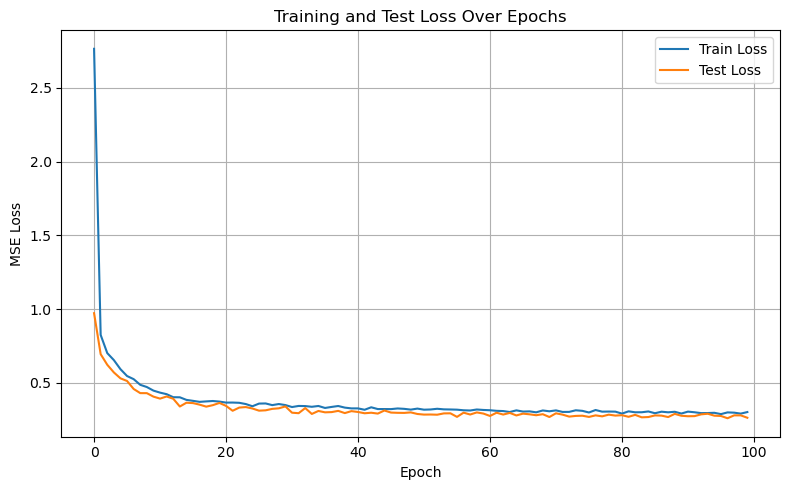

In [8]:
# Plot training and test loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
torch.save(model.state_dict(), "bnn_qubit_model.pth")